<a href="https://colab.research.google.com/github/xsuryanshx/Caption-and-Attributes-Prediction-/blob/main/TM_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Mercato Assignment Submission
* Name - Suryansh Singh Rawat
* Email - suryanshsinghrawat@gmail.com
* Phone - +917722035623

**Note**
* The model will predict the Material, Pattern
and Neckline attribute for the same image URL input.
* We are free to take your assumptions and solve the problem.
* We are assuming that the input images in the model will be downloaded already.
* The model gives a decent overall accuracy (~95%) and the performance on unseen images is also decent. 

Requirements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import string
import pickle
import cv2
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, imagenet_utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization, Input, \
                                    LSTM, Embedding, Input, TimeDistributed, Bidirectional, Activation, RepeatVector, Concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/TM Assignment

/content/drive/MyDrive/TM Assignment


In [ ]:
df = pd.read_excel('dataset 1.xlsx')
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round Neck,/images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round Neck,/images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round Neck,/images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,/images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,/images/pic_4.jpg


In [ ]:
#Adding a '.' before the image path to access it
df['Image_Path'] = '.'+df['Image_Path']
imgpath = df['Image_Path']
material = df['Material']
pattern = df['Pattern']
neckline = df['Neckline']

In [ ]:
#Adding a '_' in place of spaces so that tokenizer considers them as a single word
for i in range(len(neckline)):
  neckline[i] = neckline[i].replace(' ','_')
for i in range(len(pattern)):
  pattern[i] = pattern[i].replace(' ','_')
for i in range(len(material)):
  material[i] = material[i].replace(' ','_')

In [ ]:
#dataset with above changes
df.head()

,Title,Description,Material,Pattern,Neckline,Image_Path
0,Peach Poly Crepe jumpsuit,This stylish foil print kurta from janasya is ...,Crepe,Printed,Round_Neck,./images/pic_0.jpg
1,Light Brown Bias Yoke Checks Top,This check pattern top by Work Label is crafte...,Cotton,Checks,Round_Neck,./images/pic_1.jpg
2,Off White Geometric Straight Cotton Dobby Top ...,"Featuring elegant printed details, this off wh...",Viscose,Checks,Round_Neck,./images/pic_2.jpg
3,Blue Me Away Cape Top,Add an extra dose of style to your casual ward...,Polyester,Solid/Plain,V-Neck,./images/pic_3.jpg
4,Yellow On A High Gown,Yellow polyester georgette maxi dress. Polyest...,Polyester,Solid/Plain,V-Neck,./images/pic_4.jpg


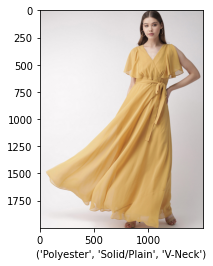

In [ ]:
k = 4 #random number from 0-499
img = cv2.imread(imgpath[k])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xlabel((material[k],pattern[k],neckline[k]));

In [ ]:
#importing and downloading the pretrained weights from ResNet50
ResNet = ResNet50(include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
ResNet_model = ResNet50(weights='imagenet')
ResNet_model = Model(inputs=ResNet_model.inputs, outputs=ResNet_model.layers[-2].output)
ResNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
imgfeatures = {}
count = 0
for i in range(len(imgpath)):
  img = cv2.imread(imgpath[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(224,224))
  img = img.reshape(1,224,224,3)
  imgfeatures[imgpath[i]] = ResNet_model.predict(img)[0]
  count+=1
  if count%50 == 0:
    print(count,'image features predicted')

50 image features predicted
100 image features predicted
150 image features predicted
200 image features predicted
250 image features predicted
300 image features predicted
350 image features predicted
400 image features predicted
450 image features predicted
500 image features predicted


In [12]:
#Creating dictionaries of eack attribute (material,pattern,neckline)
material_catalouge = {}
for i in range(len(imgpath)):
  material_catalouge[imgpath[i]] = material[i]
pattern_catalouge = {}
for i in range(len(imgpath)):
  pattern_catalouge[imgpath[i]] = pattern[i]
neckline_catalouge = {}
for i in range(len(imgpath)):
  neckline_catalouge[imgpath[i]] = neckline[i]

In [13]:
#Tokenizer for material attribute
tokenizer1 = Tokenizer(filters='!')
data1 = []
for i in range(len(imgpath)):
  data1.append(material_catalouge[imgpath[i]])
tokenizer1.fit_on_texts(data1)
total_words1 = int(len(tokenizer1.word_index))+1
print(total_words1)
print(tokenizer1.word_index)
print(tokenizer1.word_counts)

31
{'polyester': 1, 'cotton': 2, 'viscose': 3, 'crepe': 4, 'rayon': 5, 'georgette': 6, 'satin': 7, 'linen': 8, 'knitted': 9, 'denim': 10, 'nylon': 11, 'velvet': 12, 'silk': 13, 'chiffon': 14, 'organza': 15, 'net': 16, 'crinkled': 17, 'khadi': 18, 'polycotton': 19, 'leather': 20, 'organic': 21, 'polyamide': 22, 'lyocell': 23, 'lace': 24, 'suede': 25, 'wool': 26, 'modal': 27, 'poplin': 28, 'sequin': 29, 'blended_fabric': 30}
OrderedDict([('crepe', 40), ('cotton', 129), ('viscose', 57), ('polyester', 147), ('denim', 6), ('rayon', 33), ('crinkled', 2), ('georgette', 14), ('satin', 12), ('khadi', 2), ('knitted', 7), ('velvet', 5), ('linen', 12), ('silk', 5), ('chiffon', 4), ('leather', 1), ('organic', 1), ('organza', 3), ('nylon', 6), ('polyamide', 1), ('polycotton', 2), ('lyocell', 1), ('lace', 1), ('suede', 1), ('wool', 1), ('net', 3), ('modal', 1), ('poplin', 1), ('sequin', 1), ('blended_fabric', 1)])


In [14]:
#Tokenizer for pattern attribute
tokenizer2 = Tokenizer(filters='!')
data2 = []
for i in range(len(imgpath)):
  data2.append(pattern_catalouge[imgpath[i]])
tokenizer2.fit_on_texts(data2)
total_words2 = int(len(tokenizer2.word_index))+1
print(total_words2)
print(tokenizer2.word_index)
print(tokenizer2.word_counts)

19
{'solid/plain': 1, 'printed': 2, 'floral': 3, 'stripes': 4, 'embellished/sequined': 5, 'polka_dots': 6, 'checks': 7, 'embroidered': 8, 'patterned': 9, 'detailing': 10, 'ruffled': 11, 'pleated': 12, 'geometric': 13, 'mirror_work': 14, 'animal_print': 15, 'ombre': 16, 'plaid': 17, 'tie_&_dye': 18}
OrderedDict([('printed', 81), ('checks', 15), ('solid/plain', 204), ('floral', 62), ('mirror_work', 1), ('stripes', 36), ('patterned', 12), ('detailing', 9), ('ruffled', 8), ('geometric', 5), ('polka_dots', 19), ('embellished/sequined', 23), ('embroidered', 13), ('pleated', 8), ('animal_print', 1), ('ombre', 1), ('plaid', 1), ('tie_&_dye', 1)])


In [15]:
#Tokenizer for neckline attribute
tokenizer3 = Tokenizer(filters='!')
data3 = []
for i in range(len(imgpath)):
  data3.append(neckline_catalouge[imgpath[i]])
tokenizer3.fit_on_texts(data3)
total_words3 = int(len(tokenizer3.word_index))+1
print(total_words3)
print(tokenizer3.word_index)
print(tokenizer3.word_counts)

23
{'v-neck': 1, 'round_neck': 2, 'collar_neck': 3, 'shoulder_straps': 4, 'high_neck': 5, 'boat_neck': 6, 'mandarin_neck': 7, 'off_shoulder': 8, 'square_neck': 9, 'halter_neck': 10, 'keyhole_neck': 11, 'crew_neck': 12, 'one_shoulder': 13, 'sweetheart': 14, 'plunging_neck': 15, 'strapless/tube': 16, 'hooded': 17, 'ruffled_neck': 18, 'scoop_neck': 19, 'cowl_neck': 20, 'queen_anne': 21, 'cold_shoulder': 22}
OrderedDict([('round_neck', 103), ('v-neck', 113), ('off_shoulder', 18), ('collar_neck', 56), ('high_neck', 32), ('keyhole_neck', 10), ('ruffled_neck', 2), ('shoulder_straps', 47), ('sweetheart', 6), ('crew_neck', 10), ('square_neck', 17), ('halter_neck', 11), ('mandarin_neck', 23), ('boat_neck', 25), ('plunging_neck', 6), ('one_shoulder', 10), ('strapless/tube', 4), ('hooded', 3), ('scoop_neck', 1), ('cowl_neck', 1), ('queen_anne', 1), ('cold_shoulder', 1)])


In [16]:
#Creating input sequence for material attribute
input_sequence1 = []
image_input1 = []
for j in range(len(data1)):
  token_list = tokenizer1.texts_to_sequences([data1[j]])[0][0]
  input_sequence1.append(token_list)
  image_input1.append(imgfeatures[imgpath[j]])
print(len(input_sequence1))
print(len(image_input1))

500
500


In [17]:
#input and output for predicting material attribute
x1 = image_input1
y1 = tf.keras.utils.to_categorical(input_sequence1, num_classes=total_words1)

x1 = np.array(x1)
y1 = np.array(y1)
x1.shape,y1.shape

((500, 2048), (500, 31))

In [19]:
#Creating input sequence for pattern attribute
input_sequence2 = []
image_input2 = []
for j in range(len(data2)):
  token_list = tokenizer2.texts_to_sequences([data2[j]])[0][0]
  input_sequence2.append(token_list)
  image_input2.append(imgfeatures[imgpath[j]])
print(len(input_sequence2))
print(len(image_input2))

500
500


In [20]:
#input and output for predicting pattern attribute
x2 = image_input2
y2 = tf.keras.utils.to_categorical(input_sequence2, num_classes=total_words2)

x2 = np.array(x2)
y2 = np.array(y2)
x2.shape,y2.shape

((500, 2048), (500, 19))

In [21]:
#Creating input sequence for neckline attribute
input_sequence3 = []
image_input3 = []
for j in range(len(data3)):
  token_list = tokenizer3.texts_to_sequences([data3[j]])[0][0]
  input_sequence3.append(token_list)
  image_input3.append(imgfeatures[imgpath[j]])
print(len(input_sequence3))
print(len(image_input3))

500
500


In [22]:
#input and output for predicting neckline attribute
x3 = image_input3
y3 = tf.keras.utils.to_categorical(input_sequence3, num_classes=total_words3)

x3 = np.array(x3)
y3 = np.array(y3)
x3.shape,y3.shape

((500, 2048), (500, 23))

Model Training for Material

In [26]:
model1 = Sequential()
model1.add(Dense(100, input_dim=2048, activation='relu'))
model1.add(Dense(units=256))
model1.add(Dropout(0.5))
model1.add(Dense(units=256))
model1.add(Dropout(0.5))
model1.add(Dense(units=128))
model1.add(Dropout(0.2))
model1.add(Dense(total_words1, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()
history1 = model1.fit(x1, y1, epochs=300, batch_size=32, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               25856     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

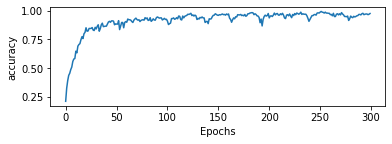

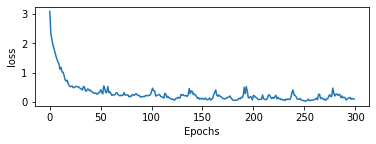

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()
plt.subplot(2,1,1) 
plot_graphs(history1, 'accuracy')
plt.subplot(2,1,2) 
plot_graphs(history1, 'loss')

Model Training for Patterns

In [36]:
model2 = Sequential()
model2.add(Dense(100, input_dim=2048, activation='relu'))
model2.add(Dense(units=256))
model2.add(Dropout(0.5))
model2.add(Dense(units=256))
model2.add(Dropout(0.5))
model2.add(Dense(units=128))
model2.add(Dropout(0.2))
model2.add(Dense(total_words2, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
history2 = model2.fit(x2, y2, epochs=300, batch_size=32, verbose=2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               25856     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

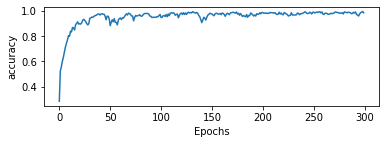

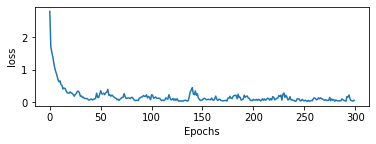

In [38]:
plt.subplot(2,1,1) 
plot_graphs(history2, 'accuracy')
plt.subplot(2,1,2) 
plot_graphs(history2, 'loss')

Model Training for Neckline

In [41]:
model3 = Sequential()
model3.add(Dense(100, input_dim=2048, activation='relu'))
model3.add(Dense(units=256))
model3.add(Dropout(0.5))
model3.add(Dense(units=256))
model3.add(Dropout(0.5))
model3.add(Dense(units=128))
model3.add(Dropout(0.2))
model3.add(Dense(total_words3, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()
history3 = model3.fit(x3, y3, epochs=300, batch_size=32, verbose=2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 100)               204900    
_________________________________________________________________
dense_36 (Dense)             (None, 256)               25856     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)              

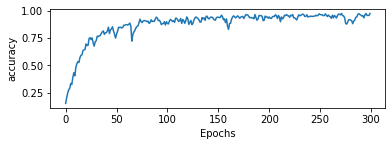

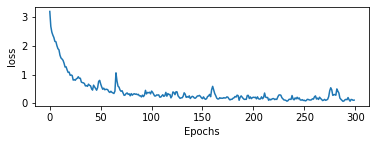

In [42]:
plt.subplot(2,1,1) 
plot_graphs(history3, 'accuracy')
plt.subplot(2,1,2) 
plot_graphs(history3, 'loss')

Function for predicting the Clothing attributes

In [51]:
def predict_img_attributes(path):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img1 = cv2.resize(img,(224,224))
  img2 = img1.reshape(1,224,224,3)
  img_inp = np.array(ResNet_model.predict(img2)[0]).reshape(1,2048)
  output_material = ""
  output_pattern = ""
  output_neckline = ""
  predicted_material = np.argmax(model1.predict(img_inp))
  predicted_pattern = np.argmax(model2.predict(img_inp))
  predicted_neckline = np.argmax(model3.predict(img_inp))
  for word, index in tokenizer1.word_index.items():
    if index == predicted_material:
      output_material = word
  for word, index in tokenizer2.word_index.items():
    if index == predicted_pattern:
      output_pattern = word
  for word, index in tokenizer3.word_index.items():
    if index == predicted_neckline:
      output_neckline = word
  plt.imshow(img)
  print('predicted material class is ('+output_material+')\n'+
        'predicted pattern class is ('+output_pattern+')\n'+
        'predicted neckline class is ('+output_neckline+')\n')
  #plt.xlabel(('Actual attributes=',material_catalouge[path],pattern_catalouge[path],neckline_catalouge[path]));
  

Trying our model on unseen data

predicted material class is (polyester)
predicted pattern class is (solid/plain)
predicted neckline class is (round_neck)



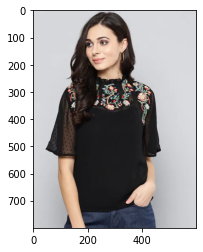

In [63]:
predict_img_attributes('./imgnew9.jpg')

predicted material class is (cotton)
predicted pattern class is (printed)
predicted neckline class is (keyhole_neck)



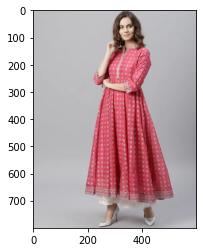

In [65]:
predict_img_attributes('./imgnew1.jpg')

predicted material class is (cotton)
predicted pattern class is (solid/plain)
predicted neckline class is (boat_neck)



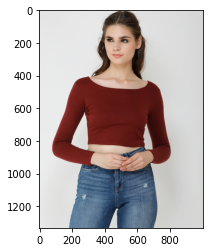

In [69]:
predict_img_attributes('./imgnew7.jpg')

predicted material class is (cotton)
predicted pattern class is (stripes)
predicted neckline class is (v-neck)



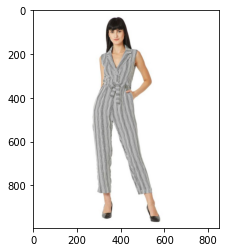

In [70]:
predict_img_attributes('./imgnew13.jpg')